In [29]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy import misc
#from pandas import read_csv
#from scipy.misc 
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import matplotlib.image as mpimg
import cv2
from IPython.display import Image
%matplotlib inline
import csv
#import io
#from skimage import io, transform
#from scikit-image
import os
import pandas

#x_mini was used so as to not be confused with x_min or normalization alternative
#These 8 lines of code need to match the same variables in drive.py
y_mini= 0
y_maxi = 40
y_dim = y_maxi-y_mini

x_mini = 0
x_maxi = 80
x_dim = x_maxi - x_mini

IMG_WIDTH = 80
IMG_HEIGHT = 40


#pandas was used to read in the data into a dataframe
#bgr was converted to YUV
#The incoming images were resized to 80 by 40
def load_data( csv, angles = 1):
    imgs = []
    angles = []
    dataframe = pandas.read_csv(csv, header=0)
    dataset = dataframe.values
    center_imgs = dataset[:,0]
    left_imgs = dataset[:,1]
    right_imgs = dataset[:,2]
    steering_angles = dataset[:,3] 
    
    zero_flag= True

    for center, left, right, angle in zip(center_imgs, left_imgs, right_imgs, steering_angles):
        path, center_file = os.path.split(center)
        #path, left_file = os.path.split(left)
        #path, right_file = os.path.split(right)
 
        center_name = mpimg.imread("IMG" + "/" + center_file)
        center_name= cv2.cvtColor(center_name, cv2.COLOR_BGR2YUV)
        
        imgs.append(cv2.resize(center_name, (IMG_WIDTH, IMG_HEIGHT )))
        angles.append(angle) 

    X = np.array(imgs, dtype='float32')
    Y = np.array(angles, dtype='float32')
    return X, Y

features, labels = load_data('driving_log.csv', 1)


#code normalize data with and options to flatten.
#I wrote a function to split bgr or YUV 
#then flatten each element 
#then normalize each element 
#then reshape them elements back to the way it started OR leave flattened 

def normalize_set(image_set, output_flat =True):

    output_set=[]   
    for i in range(0, image_set.shape[0]):
        
        #r_norm=np.array([])
        x,y,z = cv2.split(image_set[i])        
        x_flat, y_flat, z_flat = x.flatten(), y.flatten(), z.flatten()

        
        
        #many normalization formulas were tried 
        x_temp = x_flat/255
        x_norm = x_temp-0.5
        y_temp = y_flat/255
        y_norm = y_temp/0.5
        z_temp = z_flat/255
        z_norm = z_temp-0.5
        
        #r_norm = -0.5 + ((r_flat - np.min(r_flat))/ (np.max(r_flat)-np.min(r_flat)))
        #g_norm = -0.5 + ((g_flat - np.min(g_flat))/ (np.max(g_flat)-np.min(g_flat)))
        #b_norm = -0.5 + ((b_flat - np.min(b_flat))/ (np.max(b_flat)-np.min(b_flat)))

        #r_norm = cv2.normalize(r_flat, r_flat, alpha=-0.5, beta=0.5, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        #print(r_norm.shape, type(r_norm), r_norm[0:4], "rn")
        #g_norm = cv2.normalize(g_flat,g_flat, alpha=-0.5, beta=0.5, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        #b_norm = cv2.normalize(b_flat,b_flat, alpha=-0.5, beta=0.5, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
        if(output_flat):
            norm_extra_bracket = cv2.merge((r_norm,  g_norm, b_norm ))
            #print(norm_extra_bracket.shape,"f")
            norm = norm_extra_bracket[:,0,:]
            #print(norm.shape,"f_no_extra_bracket")                      
        else:
            r_norm32, g_norm32, b_norm32 =np.reshape(r_norm, (y_maxi-y_mini,x_maxi - x_mini)), np.reshape(g_norm, (y_maxi-y_mini,x_maxi - x_mini)),np.reshape(b_norm, (y_maxi-y_mini,x_maxi - x_mini))
            norm  = cv2.merge((r_norm32, g_norm32, b_norm32))
        output_set.append(norm)
    return np.array(output_set)  
 
#print(type(features))
#print(features.shape) 
#print(features[0:5].shape)
#features =normalize_set(features, True)
features =normalize_set(features, False)
#print(features.shape)




from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import matplotlib.image as mpimg
import cv2
from IPython.display import Image
from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline


batch_size = 30
nb_epoch = 2

# input image dimensions
img_rows, img_cols = (y_maxi - y_mini),(x_maxi - x_mini)
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)
#added for final play ground
kernel_size_2 = (5, 5)

#change input names
X_train = features
Y_train = labels

#print(K.image_dim_ordering())
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
    
#A data generator was used to generate more data for better accuracy    
train_datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.02,
        fill_mode='nearest')    
    
train_generator = train_datagen.flow(X_train, Y_train, batch_size=128)  
    
#FULL
model = Sequential()
model.add(Convolution2D(24, 5, 5, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), border_mode='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(48, 5, 5, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, init='normal'))  

learning_rate= 0.001#0.00001
optimizer = Adam(lr=learning_rate)
#optimizer = "Adam"
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
#history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, validation_split=0.3, shuffle=True)
model.fit_generator(
        train_generator,
        samples_per_epoch=20000,
        nb_epoch=5, validation_data=None)
        #,
        #validation_data=validation_generator,
        #nb_val_samples=2000)

#This code was used to check if samples results were in the correct range.        
#X_train =X_train[2000:2300]
#print (model.predict(X_train, batch_size=300))
#print (np.max(model.predict(X_train, batch_size=300)))
#print (np.min(model.predict(X_train, batch_size=300)))       
        
import json

#from models import model_from_json
json_string = model.to_json()


#model was stored as a .json and the weights as a .h5
with open('model.json', 'w') as outfile:
    json.dump(json_string, outfile)

    # save weights
    model.save_weights('model.h5')        

In [31]:
#A file name from drive_log
image0 = mpimg.imread('IMG/center_2016_12_01_13_30_48_287.jpg')

In [32]:
print(image0.shape)

(160, 320, 3)


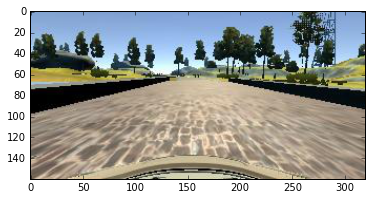

In [34]:
cropped = image0
plt.imshow(cropped)

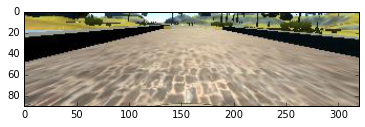

In [35]:
cropped = image0[50:140, 0:320]
plt.imshow(cropped)

(40, 80, 3)


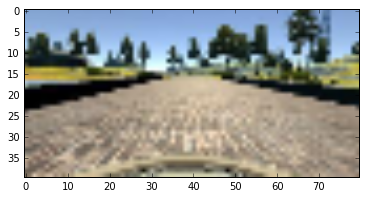

In [37]:
resized = cv2.resize(image0, (IMG_WIDTH, IMG_HEIGHT ))
plt.imshow(resized)
print(resized.shape)

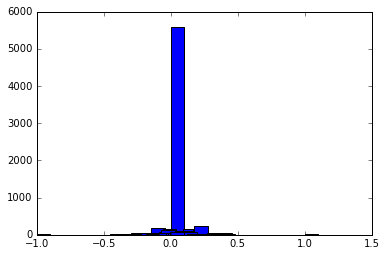

In [38]:
import matplotlib.image as mpimg
import collections
%matplotlib inline

label_count = collections.Counter(labels)
labels2, values = zip(*label_count.items())
indexes = labels2
width = 0.1
plt.bar(indexes, values, width)
plt.show()

In [ ]:
#Construct right branch
#from keras.layers import Merge

#right_branch = Sequential()
#right_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
#                        border_mode='valid',
#                        input_shape=input_shape))
#right_branch.add(Activation('relu'))
#right_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1]))
#right_branch.add(Activation('relu'))
#right_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1], border_mode='same'))
#right_branch.add(Activation('relu'))
#right_branch.add(MaxPooling2D(pool_size=pool_size))
#right_branch.add(Dropout(0.25))
#right_branch.add(Flatten())

#Construct left branch
#left_branch = Sequential()
#left_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size_2[1],
#                        border_mode='valid',
#                        input_shape=input_shape))
#left_branch.add(Activation('relu'))
#left_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size_2[1]))
#left_branch.add(Activation('relu'))
#left_branch.add(Convolution2D(nb_filters, kernel_size[0], kernel_size_2[1]))
#left_branch.add(Activation('relu'))
#left_branch.add(MaxPooling2D(pool_size=pool_size))
#left_branch.add(Dropout(0.25))
#left_branch.add(Flatten())



#Merge branches and construct final model
#merged = Merge([left_branch, right_branch], mode='concat')

#final_model = Sequential()
#final_model.add(merged)

#final_model.add(Dense(128))
#final_model.add(Activation('relu'))
#final_model.add(Dropout(0.5))
#final_model.add(Dense(nb_classes))
#final_model.add(Activation('softmax'))

#final_model.summary()

#compile and train
#final_model.compile(loss='categorical_crossentropy',
#              optimizer='adadelta',
#              metrics=['accuracy'])

#    history = final_model.fit([X_train, X_train], Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
#          verbose=1, validation_data=([X_val,X_val], Y_val))

#score = final_model.evaluate([X_val,X_val], Y_val, verbose=0)
#print('Val score:', score[0])
#print('Val accuracy:', score[1])